# Estudio de un dataset e implementación de un modelo de regressión lineal sobre el mismo
#### Juan Carlos Soriano (1493037) y Jorge Giménez (1493035)

## Estudio del dataset

### 1. Primeramente realizamos los imports necesarios y ajustamos algunas opciones de visualización

In [196]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 15) 

### 2. Cargamos el dataset usando pandas y revisamos algunos datos de referéncia:

In [197]:
dataFrame = pd.read_csv('./Database/Concrete_Data_Yeh.csv', header=0, delimiter=',')

- Dimensiones del dataframe:

In [198]:
dataFrame.shape

(1030, 9)

Tenemos 1030 registros y 9 variables, una de las cuales es el output que quisiéramos predecir.

- Valores nulos por cada atributo:

In [199]:
dataFrame.isnull().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

No tenemos valores nulos, lo cuál es bueno.

- Descripción rápida del dataset:

In [200]:
dataFrame.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000,1030.000,1030.000,1030.000,1030.000,1030.000,1030.000,1030.000,1030.000
mean,281.168,73.896,54.188,181.567,6.205,972.919,773.580,45.662,35.818
std,104.506,86.279,63.997,21.354,5.974,77.754,80.176,63.170,16.706
min,102.000,0.000,0.000,121.800,0.000,801.000,594.000,1.000,2.330
25%,192.375,0.000,0.000,164.900,0.000,932.000,730.950,7.000,23.710
50%,272.900,22.000,0.000,185.000,6.400,968.000,779.500,28.000,34.445
75%,350.000,142.950,118.300,192.000,10.200,1029.400,824.000,56.000,46.135
max,540.000,359.400,200.100,247.000,32.200,1145.000,992.600,365.000,82.600


- Primeras 10 filas:

In [201]:
dataFrame.head(10)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.000,0.000,0.000,162.000,2.500,1040.000,676.000,28,79.990
1,540.000,0.000,0.000,162.000,2.500,1055.000,676.000,28,61.890
2,332.500,142.500,0.000,228.000,0.000,932.000,594.000,270,40.270
3,332.500,142.500,0.000,228.000,0.000,932.000,594.000,365,41.050
4,198.600,132.400,0.000,192.000,0.000,978.400,825.500,360,44.300
5,266.000,114.000,0.000,228.000,0.000,932.000,670.000,90,47.030
6,380.000,95.000,0.000,228.000,0.000,932.000,594.000,365,43.700
7,380.000,95.000,0.000,228.000,0.000,932.000,594.000,28,36.450
8,266.000,114.000,0.000,228.000,0.000,932.000,670.000,28,45.850
9,475.000,0.000,0.000,228.000,0.000,932.000,594.000,28,39.290


### 3. Hacemos unos cuántos plots que nos ayudarán a entender mejor los datos:

- Plot de un histograma por cada variable del dataset:

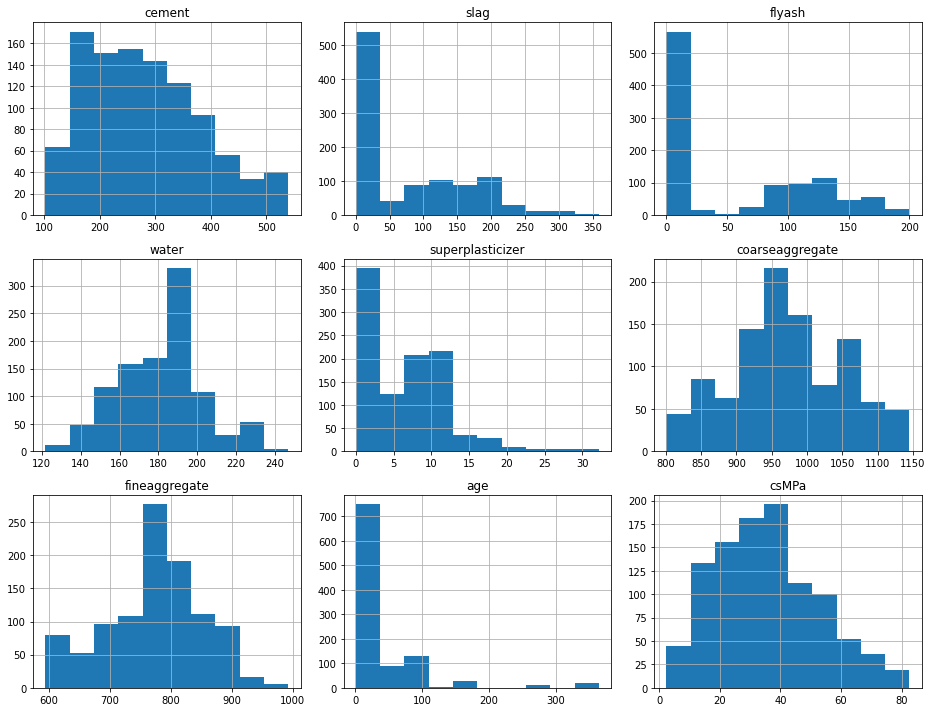

In [202]:
fig, axs = plt.subplots(3, 3)

varIdx = 0
for x in range(3):
    for y in range(3):
        plt.sca(axs[x,y])
        axs[x,y].set_title(dataFrame.columns[varIdx])
        dataFrame[dataFrame.columns[varIdx]].hist(figsize=(13,10))
        varIdx+=1

fig.tight_layout()
plt.show()

Vemos que algunas variables siguen una distribución considerablemente cercana a la gaussiana ('cement', 'water', 'fineaggregate', 'coarseaggregate' y el output 'csMPa'), sin embargo el resto de variables quedan mermadas por tener tantos registros en el valor 0, quizás sería interesante tratar esto.

- Plot de un scatterplot por variable  de entrada (cement, slag, flyash...) contra la variable output (csMPa) 

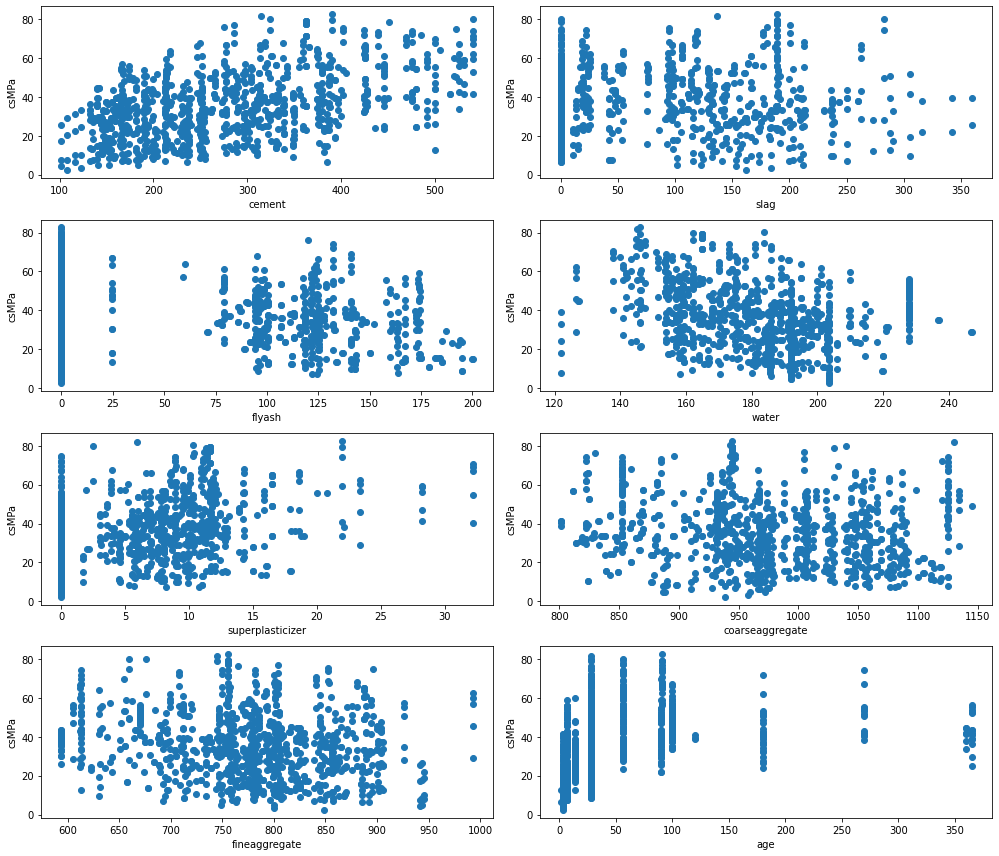

In [203]:
fig, axs = plt.subplots(4, 2, figsize=(14,12))

varIdx = 0
for x in range(4):
    for y in range(2):
        axs[x,y].set(xlabel=dataFrame.columns[varIdx], ylabel='csMPa')
        axs[x,y].plot(dataFrame[dataFrame.columns[varIdx]], dataFrame['csMPa'], 'o')
        varIdx+=1

fig.tight_layout()
plt.show()

Tras visualizar todas las variables respecto al output deseado, vemos que hay muchas medidas acumuladas en el 0 para algunas variables.
De todas formas, podemos ser bastante optimistas!

- Plot de las correlaciones entre variables:

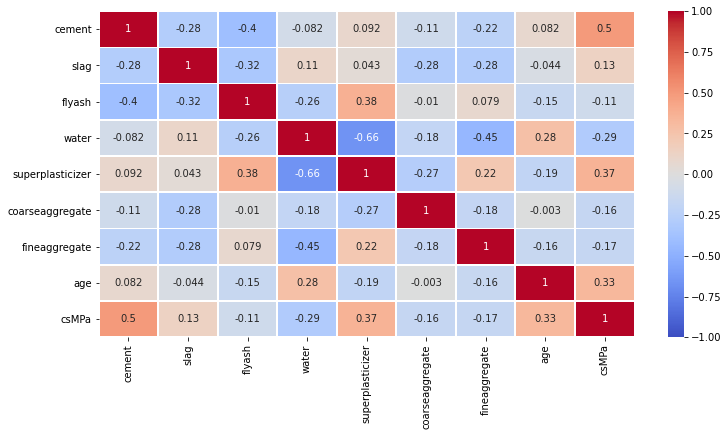

In [204]:
plt.figure(figsize = (12,6))
sns.heatmap(dataFrame.corr(), annot=True, linewidths= .75, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Determinamos que en principio las variables que deberíamos usar para hacer la regressión son: 'age', 'superplasticizer', 'water' y 'cement'.
De todas maneras, será interesante probar con la penalización LASSO para ver si realmente acaba descartando estas variables / asignandoles un valor muy bajo o si por lo contrario no estábamos en lo cierto y los resultados obtenidos con LASSO van en contra de lo que exponíamos justo ahora.

## Primer intento de regressión

Vamos a intentar hacer una regressión sin hacer nada con los datos más allá de normalizarlos, nos parece positivo tener algún resultado contra el que poder comparar posteriormente cuando vayamos aplicando mejoras.

In [205]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model

Importamos 'preprocessing' para que nos brinde un normalizador para los datos.  
Importamos 'train_test_split' para separar los datos en train y test fácil y rápidamente.  
Importamos 'linear_model' para tener disponible el modelo de regressión lineal que vamos a entrenar y testear.

In [206]:
'''
nonNormalizedValues = dataFrame.values
minMaxScaler = preprocessing.MinMaxScaler()
normalizedValues = minMaxScaler.fit_transform(nonNormalizedValues)
normalizedDataFrame = pd.DataFrame(normalizedValues)
normalizedDataFrame = dataFrame
normalizedDataFrame.head()
'''

'\nnonNormalizedValues = dataFrame.values\nminMaxScaler = preprocessing.MinMaxScaler()\nnormalizedValues = minMaxScaler.fit_transform(nonNormalizedValues)\nnormalizedDataFrame = pd.DataFrame(normalizedValues)\nnormalizedDataFrame = dataFrame\nnormalizedDataFrame.head()\n'

Ahora que ya tenemos los datos normalizados podemos empezar a separar los datos y entrenar nuestro primer modelo.  
Para hacer el paso inverso a la normalización de los datos, podemos usar 'preprocessing.inverse_transform(values)'.

In [207]:
#xTrain, xTest, yTrain, yTest = train_test_split(normalizedDataFrame.iloc[:, :8], normalizedDataFrame.iloc[:, 8:9], test_size=0.2)
xTrain, xTest, yTrain, yTest = train_test_split(dataFrame.iloc[:, :8], dataFrame.iloc[:, 8:9], test_size=0.1)
print(f'Registros de train: {len(trainData)}')
print(f'Registros de test: {len(testData)}')

Registros de train: 824
Registros de test: 206


Al elegir un tamaño de test del 20% del dataset completo, obtenemos 824 registros para entrenar el modelo y 206 registros sobre los que lo testearemos.

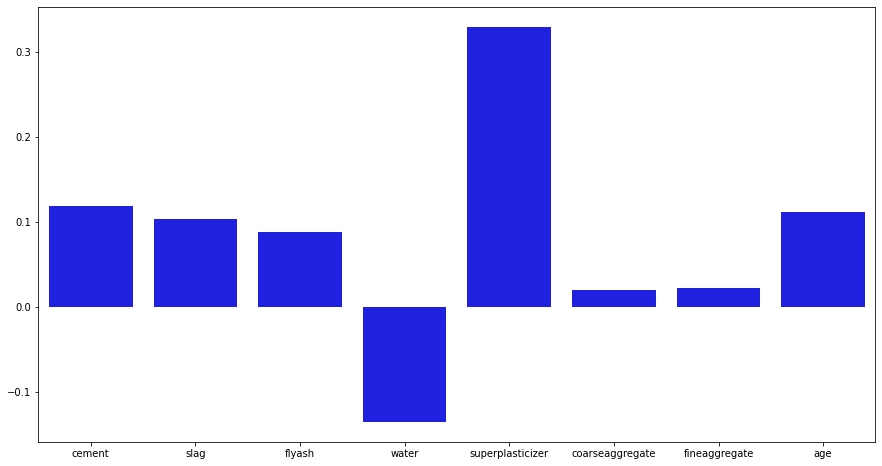

In [208]:
firstLinearModel = linear_model.LinearRegression()
firstLinearModel.fit(xTrain, yTrain)
plt.figure(figsize = (15,8))
sns.barplot(dataFrame.columns[:-1], firstLinearModel.coef_[0], color='blue')
plt.show()

Ya tenemos el primer modelo entrenado y hemos visualizado los pesos que ha otorgado a cada variable.  
Visualizems el modelo y luego veamos que scores y errores obtiene.

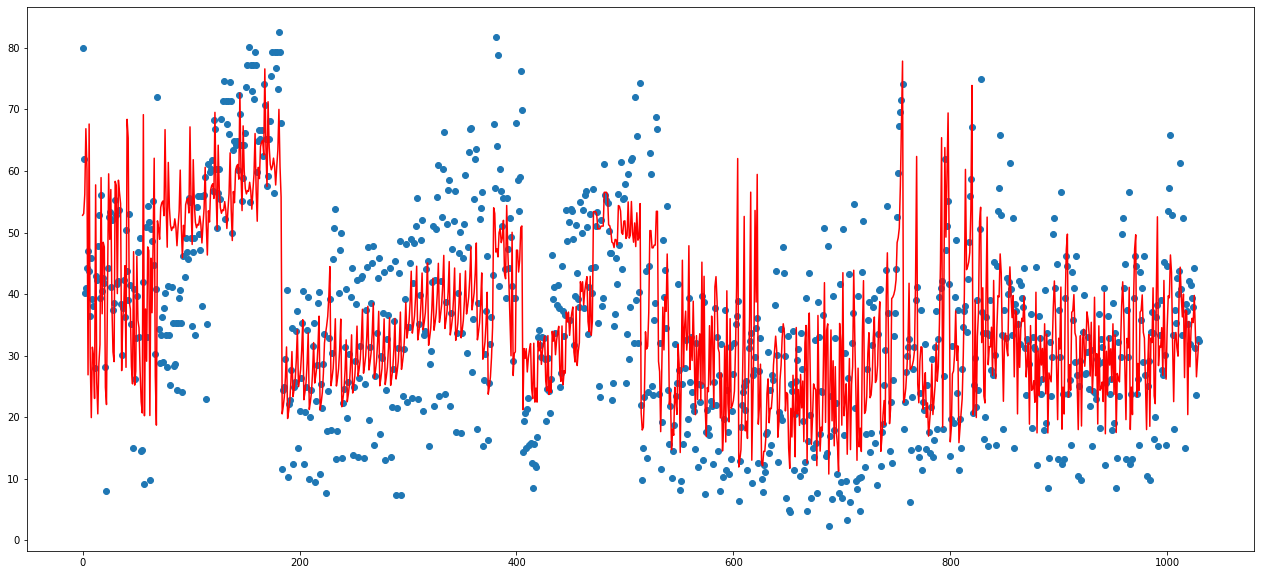

In [211]:
allPredictions = firstLinearModel.predict(dataFrame.iloc[:, :8])
x = [i for i in range(0, dataFrame.shape[0])]

plt.figure(figsize = (22,10))
plt.scatter(x,normalizedDataFrame.iloc[:, 8:9])
plt.plot(x, allPredictions, "r")
plt.show()

In [210]:
print(f'Training score: {firstLinearModel.score(xTrain, yTrain)}')
print(f'Training MSE: {np.mean((firstLinearModel.predict(xTrain) - yTrain)**2)}')
print(f'Test score: {firstLinearModel.score(xTest, yTest)}')
print(f'Test MSE: {np.mean((firstLinearModel.predict(xTest) - yTest)**2)}')

Training score: 0.6105882017952751
Training MSE: csMPa   108.204
dtype: float64
Test score: 0.6541411755318303
Test MSE: csMPa   98.821
dtype: float64
